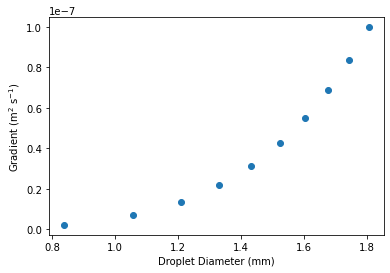

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import root
import numpy as np
import scipy.io
import os

sigma = 1
alpha = 1
gamma = 0.003
rho = 125
g = 9.8
uL = 1E-12

V = uL * np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Volume in m3
R = (4*np.pi/3)*V**(1./3.)

grad = R**5 * (rho**2 * g**2 * sigma**2)/(3 * alpha * gamma)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(2000*R, grad)
ax.set_xlabel('Droplet Diameter (mm)')
ax.set_ylabel('Gradient (m$^2$ s$^{-1}$)')
plt.show()

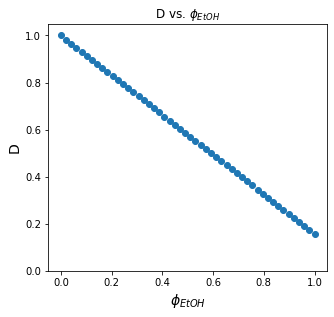

In [3]:
# Make plots of:
# 1. How D varies with %EtOH
# 2. How sigma varies with %EtOH and theta

EtOH = np.linspace(0, 1)
theta = 110
rhoA = 750
rhoB = 1000

rhoS = EtOH*789 + (1-EtOH)*1000
D = (rhoS - rhoA) / (rhoB - rhoA)
rhoS

fig = plt.figure(figsize=(11,10))
ls=14

# 1. How D varies with %EtOH
ax1 = fig.add_subplot(221)
ax1.scatter(EtOH, D)
ax1.set_ylim(0, 1.05)
ax1.set_xlabel(r'$\phi_{EtOH}$', size=ls)
ax1.set_ylabel('D', size=ls)
ax1.set_title('D vs. $\phi_{EtOH}$')


rhoS = EtOH*789 + (1-EtOH)*1000
D = (rhoS - rhoA) / (rhoB - rhoA)
theta = np.array([110, 125, 140])
theta = theta * np.pi / 180.

# # 2. How sigma varies with %EtOH
# ax2 = fig.add_subplot(222)
# for n in theta:
#     n_rad = n*np.pi/180.
#     sig = (1./3.)*((2.*D)-1.) - 0.5*np.cos(n_rad) + (1./6.)*np.cos(n_rad)**3

#     ax2.scatter(EtOH, sig**2, label=str(n) + '$^{\circ}$')
#     ax2.set_xlabel(r'$\phi_{EtOH}$', size=ls)
#     ax2.set_ylabel(r'$\Sigma^2$', size=ls)
# #     ax2.set_yscale('log')
#     ax2.legend()
#     ax2.set_title(r'$\Sigma^2$ vs. $\phi_{EtOH}$')


# plt.show()

Sigma squared is 0.2207086688440858
Sigma squared is 0.1083263893444605
Sigma squared is 0.04691400574476024


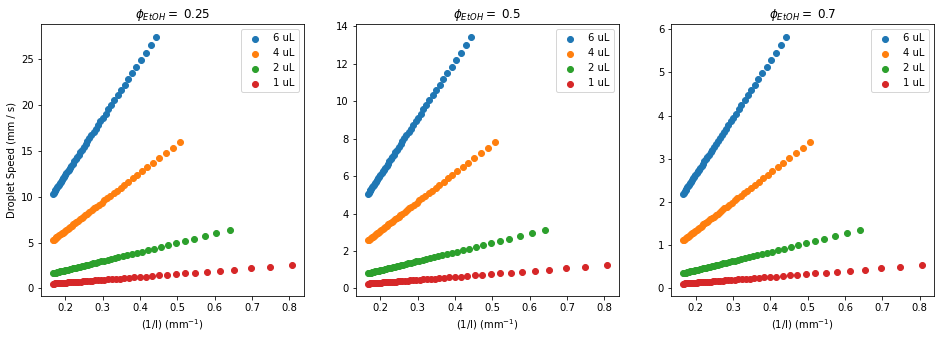

In [6]:
# Now calculate droplet speed as a function of EtOH concentration
alpha = 1
gamma = 10E-3    # Oil-water surface tension
mu = 1.3E-3     # Viscosity of dodecane
g = 9.8
rho = 250       # Oil-water density difference

EtOH = np.array([0.25, 0.5, 0.7])
V_uL = np.array([6, 4, 2, 1])
V_m3 = V_uL*1E-9
R = ((3*V_m3)/(4*np.pi))**(1/3)
theta = 130
rhoA = 750
rhoB = 1000
theta = theta*np.pi/180.    # Convert to radians

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

for idx_eth, eth in enumerate(EtOH):
    rhoS = eth*789 + (1-eth)*1000
    D = (rhoS - rhoA) / (rhoB - rhoA)
    sig = (1./3.)*((2.*D)-1.) - 0.5*np.cos(theta) + (1./6.)*np.cos(theta)**3
    print('Sigma squared is', sig**2)
    for idx_r, r in enumerate(R):
        l = np.linspace(2*r, 6E-3)
        a = (rho * rho * g * g * sig * sig)/(3*alpha*gamma*mu)
        b = r**5
        v = (1/l)*a*b
#         axes[idx_eth].scatter(1000*l, 1000*v, label= str(V_uL[idx_r]) + ' uL')
        axes[idx_eth].scatter((1/l)/1000, 1000*v, label= str(V_uL[idx_r]) + ' uL')
    axes[idx_eth].legend()
    axes[idx_eth].set_title('$\phi_{EtOH} =$ ' + str(eth))
    axes[idx_eth].set_xlabel('(1/l) (mm$^{-1}$)')
    axes[0].set_ylabel('Droplet Speed (mm / s)')
    
# plt.show()
plt.savefig('Droplet_Speeds_NoInterfaceDrag.png', dpi=300, bbox_inches='tight')


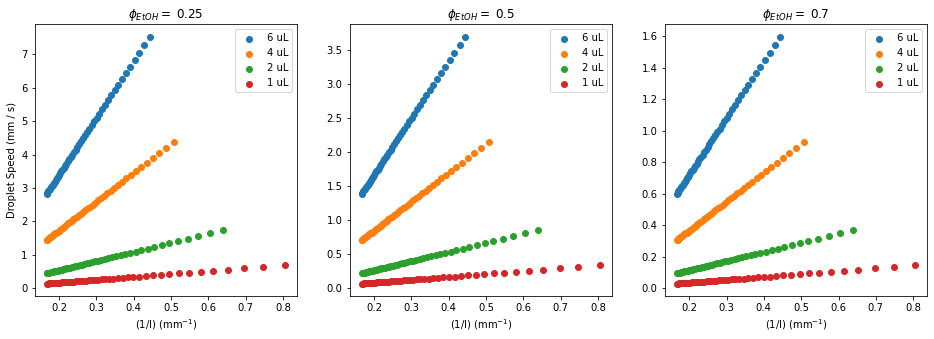

In [7]:
# Calculating speed with solid-liquid drag term added
# Note you can try and introduce contact line hysteresis by varying delta
alpha = 1
gamma = 10E-3    # Oil-water surface tension
mu = 1.3E-3     # Viscosity of dodecane
g = 9.8
rho = 250       # Oil-water density difference

EtOH = np.array([0.25, 0.5, 0.7])
V_uL = np.array([6, 4, 2, 1])
V_m3 = V_uL*1E-9
R = ((3*V_m3)/(4*np.pi))**(1/3)
theta = 130
delta = 0
theta_r = theta - delta
theta_a = theta + delta
rhoA = 750
rhoB = 1000
theta = theta*np.pi/180.    # Convert to radians
theta_r = theta_r*np.pi/180.    # Convert to radians
theta_a = theta_a*np.pi/180.    # Convert to radians
ln = 12

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

for idx_eth, eth in enumerate(EtOH):
    rhoS = eth*789 + (1-eth)*1000
    D = (rhoS - rhoA) / (rhoB - rhoA)
    sig = (1./3.)*((2.*D)-1.) - 0.5*np.cos(theta) + (1./6.)*np.cos(theta)**3
    for idx_r, r in enumerate(R):
        Fh = -(0.01)*np.pi*r*gamma*(np.cos(theta_r) - np.cos(theta_a))
        
        l = np.linspace(2*r, 6E-3)
        a = (2*np.pi * sig * sig * rho * rho * g * g) / gamma
        b = r**6
        Fc = (1/l)*a*b
        
        # speed-independent side
        v_ind = Fh + Fc
        
        Fv = 3*np.pi*mu*ln*r / theta
        Fs = 6*np.pi*mu*alpha*r
        v_dep = 1/(Fv + Fs)
        
        v = v_ind * v_dep
        
        # Finally, identify regions where v < 0 and set to 0
        v[np.where(v < 0)] = 0
        
#         axes[idx_eth].scatter(1000*l, 1000*v, label= str(V_uL[idx_r]) + ' uL')
        axes[idx_eth].scatter((1/l)/1000, 1000*v, label= str(V_uL[idx_r]) + ' uL')
    
    axes[idx_eth].legend()
    axes[idx_eth].set_title('$\phi_{EtOH} =$ ' + str(eth))
    axes[idx_eth].set_xlabel('(1/l) (mm$^{-1}$)')
    axes[0].set_ylabel('Droplet Speed (mm / s)')
#     axes[idx_eth].set_xscale('log')
#     axes[idx_eth].set_yscale('log')
    
# plt.show()
plt.savefig('Droplet_Speeds_SurfaceDrag.png', dpi=300, bbox_inches='tight')



R is 0.000984745021842697
phi_c is 79.5726290102879
R is 0.000984745021842697
phi_c is 63.953445574736214
R is 0.000984745021842697
phi_c is 57.53580456826622
R is 0.000984745021842697
phi_c is 51.630898498881386


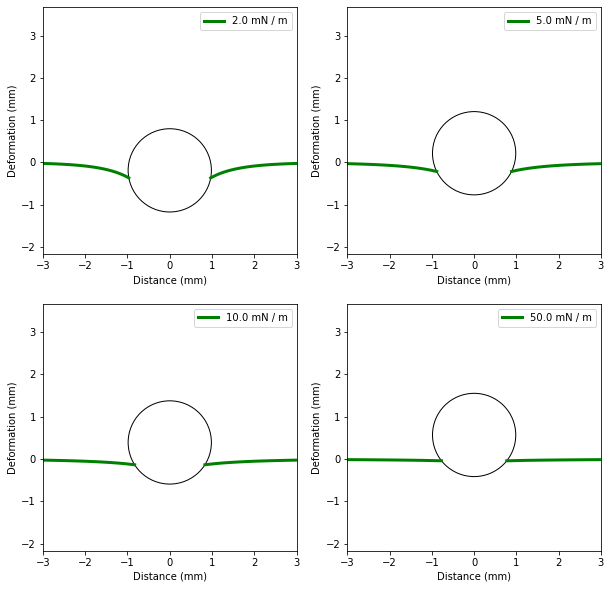

In [9]:
# Plotting membrane deformation
from scipy.special import kn
import matplotlib.pyplot as plt
import numpy as np

def phi_c_func(x):
    return np.sin(x)*np.tan(x + theta - np.pi) - geom

# Calculate capillary length
gamma = [2E-3, 5E-3, 10E-3, 50E-3]    # N / m
g = 9.8          # m / s2
V_uL = 4     # microlitres
# Densities
rhoA = 750
rhoB = 1000
eth = 0.25    # ethanol volume fraction
theta = 130    # Degrees
theta = theta*np.pi/180.    # Convert to radians

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(10,10))

for idx, ift in enumerate(gamma):
    # Droplet size
    V_m3 = V_uL*1E-9
    R = ((3*V_m3)/(4*np.pi))**(1./3.)    # Radius in metres
    print('R is', R)
    delta_rho = rhoB - rhoA
    B = delta_rho*g*R*R/ift
    
    rhoS = eth*789 + (1-eth)*1000
    D = (rhoS - rhoA) / delta_rho
    lamb = np.sqrt(delta_rho * g / ift)    # 5 mm or so
    
    geom = B*((2./3.)*D - (1./3.) - (1./2.)*np.cos(theta) + (1./6.)*(np.cos(theta)**3))
    phi_c = root(phi_c_func, 1, method='hybr').x[0]   # Numerically solve for phi_c
    print('phi_c is', phi_c*180/np.pi)
    dot_z_c = np.tan(phi_c + theta - np.pi)
    x_c = R*np.sin(phi_c)    # "Sphere is identical with x replace by r" - use x-distance not arc distance
    
    # kn(n, x) = Modified Bessel function of the second kind of integer order n
    # Modified Bessel function of 2nd kind, order 1
    norm = dot_z_c / (lamb*kn(1, lamb*x_c))

    # Modified Bessel function of 2nd kind, order 0
    z_c = norm * kn(0, lamb*x_c) 
    z_imm = R*(1 - np.cos(phi_c))   # Immersion depth   
    
    # r in units of capillary length
    x = np.linspace(x_c*lamb, 5)
    
    # Modified Bessel function of 2nd kind, order 0
    y = -1000 * norm * kn(0, x)   # Convert to mm
    
    x_real = 1000*x / lamb       # Convert to mm

    i = idx // ncols
    j = idx % ncols
    axes[i, j].plot(x_real, y, label = str(1000*ift) + ' mN / m', c='green', lw=3)
    axes[i, j].plot(-1*x_real, y, c='green', lw=3)

    circle = plt.Circle((0,(R - z_c - z_imm)*1000), 1000*R, fill=False)
    axes[i, j].add_artist(circle)

    axes[i, j].set_xlabel('Distance (mm)')
    axes[i, j].set_ylabel('Deformation (mm)')
    axes[i, j].legend(loc = 'upper right')
    axes[i, j].axis('equal')
    axes[i, j].set_ylim(0, 1.5)
    axes[i, j].set_xlim(-3, 3)
# plt.show()
plt.savefig('4uL_0-25EtOH.png', dpi=300, bbox_inches='tight')

In [ ]:
#####
# Code Leftovers
#####

x_c = R*np.sin(phi_c)    # "Sphere is identical with x replace by r" - use x-distance not arc distance
# Modified Bessel function of 2nd kind, order 1
norm = dot_z_c / (lamb*kn(1, lamb*r_c))
y_c = -1000 * norm * kn(0, x_c)   # Convert to mm

fig = plt.figure()
ax = fig.add_subplot()
circle = plt.Circle((0,R*1000), 0.2, transform=ax.transData._b, color="red", alpha=0.4)
ax.add_artist(circle)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('equal')

# Calculate y(x_c)
# x_real
x_c = R*np.sin(phi_c)    # "Sphere is identical with x replace by r" - use x-distance not arc distance
# Modified Bessel function of 2nd kind, order 1
norm = dot_z_c / (lamb*kn(1, lamb*r_c))
y_c = -1000 * norm * kn(0, x_c)   # Convert to mm

R = R*1000
x = np.linspace(0, R)
y = np.sqrt(R**2 - x**2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, c='blue')
ax.plot(x, -1*y, c='blue')
ax.plot(-1*x, y, c='blue')
ax.plot(-1*x, -1*y, c='blue')
ax.axis('equal')
plt.show()


# Numerically calculate phi_c
geom = B*((2./3.)*D - (1./3.) - (1./2.)*np.cos(theta) + (1./6.)*(np.cos(theta)**3))

def fun(x):
    return np.sin(x)*np.tan(x + theta - np.pi) - geom

sol = root(fun, 1, method='hybr')   # Numerically solve above function
phi_c = sol.x
z_dot_c = np.tan(phi_c + theta - np.pi)

x = np.linspace(-2*np.pi, 2*np.pi, 500)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, fun(x))
ax.plot(x, [0]*len(x))
ax.scatter(phi_c, 0)
ax.set_ylim(-1, 1)
plt.show()